In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import time

In [8]:
# Load the clustered anomalies data
df = pd.read_csv('clustered_anomalies_filtered.csv')
print(f"Loaded data shape: {df.shape}")
print(f"Anomaly types: {df['anomaly_type'].unique()}")
print(f"Anomaly distribution:\n{df['anomaly_type'].value_counts()}")

Loaded data shape: (20000, 14)
Anomaly types: ['LightLoad_Undervoltage_LowPF' 'LightLoad_SeverePF' 'Idle_Stable'
 'LightLoad_Undervoltage' 'HighLoad_SevereTransients'
 'ModeratePF_MinorSurge' 'Idle_Undervoltage' 'HighLoad_Optimal'
 'LightLoad_VoltageSurge' 'HighLoad_MixedAnomalies' 'HighLoad_Excellent'
 'HighLoad_VoltageInstability' 'Idle_Overvoltage' 'LightLoad_MinorSurge'
 'PeakLoad_Excellent']
Anomaly distribution:
anomaly_type
LightLoad_Undervoltage_LowPF    5238
LightLoad_Undervoltage          3154
LightLoad_SeverePF              2093
ModeratePF_MinorSurge           1648
Idle_Stable                     1601
HighLoad_Optimal                 996
Idle_Overvoltage                 867
LightLoad_MinorSurge             860
LightLoad_VoltageSurge           855
HighLoad_Excellent               837
Idle_Undervoltage                505
HighLoad_VoltageInstability      489
HighLoad_MixedAnomalies          361
HighLoad_SevereTransients        315
PeakLoad_Excellent               181
Name: coun

In [9]:
# Define the features we'll use for classification (same as clustering)
feature_cols = [
    'voltage', 'current', 'frequency', 'power', 'powerFactor',
    'voltage_deviation', 'frequency_deviation', 'pf_deviation',
    'power_voltage_ratio', 'current_voltage_ratio'
]

# Prepare features and target
X = df[feature_cols]
y = df['anomaly_type']  # The labels derived from clustering

# Quick check of features
print(X.describe().round(3))

         voltage    current  frequency      power  powerFactor  \
count  20000.000  20000.000  20000.000  20000.000    20000.000   
mean     226.213      2.009     59.966    429.323        0.627   
std       14.713      4.408      0.094   1012.592        0.304   
min      152.300      0.000     59.600      0.000        0.000   
25%      210.500      0.193     59.900     32.400        0.510   
50%      228.900      0.324     60.000     40.300        0.750   
75%      239.900      0.942     60.000    146.600        0.790   
max      249.500     31.016     60.500   7497.200        1.000   

       voltage_deviation  frequency_deviation  pf_deviation  \
count          20000.000            20000.000     20000.000   
mean              -0.016               -0.001        -0.373   
std                0.064                0.002         0.304   
min               -0.338               -0.007        -1.000   
25%               -0.085               -0.002        -0.490   
50%               -0.005   

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features (important for some models like SVM and MLP)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (14000, 10), Test set: (6000, 10)


In [11]:
# Define the models to evaluate
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "GBM": GradientBoostingClassifier(random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,50), max_iter=1000, random_state=42)
}

# Train and evaluate each model
results = {}
model_objects = {}  # Store the trained models for later use

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Use scaled data for SVM and MLP, unscaled for others
    if name in ["SVM", "MLP", "Logistic Regression"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Calculate performance metrics
    train_time = time.time() - start_time
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Training completed in {train_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{report}")
    
    # Store results
    results[name] = {
        'accuracy': accuracy, 
        'report': report,
        'training_time': train_time
    }
    model_objects[name] = model


Training Decision Tree...
Training completed in 0.11 seconds
Accuracy: 0.9967
Classification Report:
                              precision    recall  f1-score   support

          HighLoad_Excellent       0.99      1.00      1.00       272
     HighLoad_MixedAnomalies       0.99      0.99      0.99       119
            HighLoad_Optimal       0.99      1.00      1.00       300
   HighLoad_SevereTransients       1.00      0.98      0.99        90
 HighLoad_VoltageInstability       0.99      0.99      0.99       131
            Idle_Overvoltage       1.00      1.00      1.00       269
                 Idle_Stable       1.00      1.00      1.00       472
           Idle_Undervoltage       0.98      0.99      0.98       158
        LightLoad_MinorSurge       1.00      0.98      0.99       267
          LightLoad_SeverePF       1.00      0.99      1.00       583
      LightLoad_Undervoltage       1.00      1.00      1.00       957
LightLoad_Undervoltage_LowPF       1.00      1.00      1.


Best model: Random Forest with accuracy 0.9973


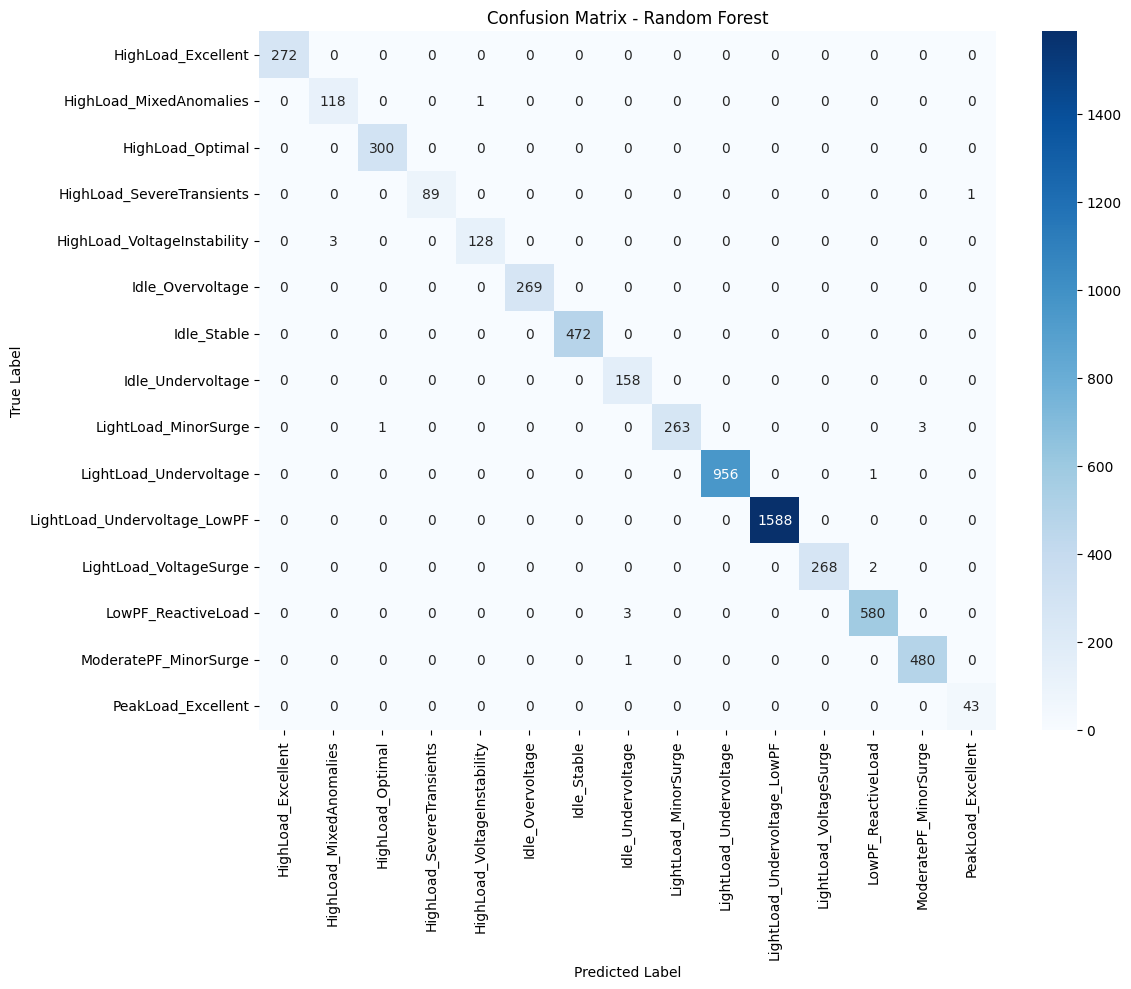

In [7]:
# Find the best performing model based on accuracy
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
print(f"\nBest model: {best_model_name} with accuracy {results[best_model_name]['accuracy']:.4f}")

# Generate confusion matrix for the best model
plt.figure(figsize=(12, 10))

if best_model_name in ["SVM", "MLP", "Logistic Regression"]:
    y_pred = model_objects[best_model_name].predict(X_test_scaled)
else:
    y_pred = model_objects[best_model_name].predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('supervised_plots/confusion_matrix.png')
plt.show()

In [8]:
# Create a summary DataFrame of model performance
summary_data = {
    'Model': [],
    'Accuracy': [],
    'Training Time (s)': []
}

for name, res in results.items():
    summary_data['Model'].append(name)
    summary_data['Accuracy'].append(res['accuracy'])
    summary_data['Training Time (s)'].append(res['training_time'])

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Accuracy', ascending=False)
print("\nModel Performance Summary:")
print(summary_df)

# Save the summary to CSV
summary_df.to_csv('model_performance_summary.csv', index=False)


Model Performance Summary:
                 Model  Accuracy  Training Time (s)
4                  GBM  0.997333          40.331693
2        Random Forest  0.997333           1.519572
0        Decision Tree  0.996667           0.066827
5                  MLP  0.995833           9.102852
1  Logistic Regression  0.992500           0.984271
3                  SVM  0.992333           3.169868


In [9]:
df['anomaly_type'].unique()

array(['LightLoad_Undervoltage_LowPF', 'LowPF_ReactiveLoad',
       'Idle_Stable', 'LightLoad_Undervoltage',
       'HighLoad_SevereTransients', 'ModeratePF_MinorSurge',
       'Idle_Undervoltage', 'HighLoad_Optimal', 'LightLoad_VoltageSurge',
       'HighLoad_MixedAnomalies', 'HighLoad_Excellent',
       'HighLoad_VoltageInstability', 'Idle_Overvoltage',
       'LightLoad_MinorSurge', 'PeakLoad_Excellent'], dtype=object)

In [14]:
y_pred

array(['Idle_Overvoltage', 'LightLoad_Undervoltage',
       'ModeratePF_MinorSurge', ..., 'LightLoad_Undervoltage_LowPF',
       'LightLoad_Undervoltage_LowPF', 'HighLoad_Optimal'], dtype=object)

In [2]:
# # Import necessary libraries
# import pandas as pd
# import numpy as np
# import joblib
# import os
# import time
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# # Create models directory if it doesn't exist
# os.makedirs('models', exist_ok=True)

# # Load the clustered anomalies data
# print("Loading data...")
# df = pd.read_csv('clustered_anomalies_filtered.csv')
# print(f"Dataset shape: {df.shape}")
# print(f"Anomaly types: {df['anomaly_type'].unique()}")

# # Define features and target
# feature_cols = [
#     'voltage', 'current', 'frequency', 'power', 'powerFactor',
#     'voltage_deviation', 'frequency_deviation', 'pf_deviation',
#     'power_voltage_ratio', 'current_voltage_ratio'
# ]
# X = df[feature_cols]
# y = df['anomaly_type']

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# # Train Random Forest model
# print("\nTraining Random Forest model...")
# start_time = time.time()
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)
# training_time = time.time() - start_time

# # Evaluate model
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Training completed in {training_time:.2f} seconds")
# print(f"Accuracy: {accuracy:.4f}")

# # Save the model
# model_path = 'models/random_forest_model.joblib'
# joblib.dump(model, model_path)
# print(f"Model saved to {model_path}")

# # Example of how to load the model
# print("\nVerifying saved model...")
# loaded_model = joblib.load(model_path)
# test_pred = loaded_model.predict(X_test[:1])
# print(f"Test prediction: {test_pred[0]}")
# print("Model saved successfully!")

Loading data...
Dataset shape: (20000, 14)
Anomaly types: ['LightLoad_Undervoltage_LowPF' 'LightLoad_SeverePF' 'Idle_Stable'
 'LightLoad_Undervoltage' 'HighLoad_SevereTransients'
 'ModeratePF_MinorSurge' 'Idle_Undervoltage' 'HighLoad_Optimal'
 'LightLoad_VoltageSurge' 'HighLoad_MixedAnomalies' 'HighLoad_Excellent'
 'HighLoad_VoltageInstability' 'Idle_Overvoltage' 'LightLoad_MinorSurge'
 'PeakLoad_Excellent']
Training set: (14000, 10), Test set: (6000, 10)

Training Random Forest model...
Training completed in 1.62 seconds
Accuracy: 0.9973
Model saved to models/random_forest_model.joblib

Verifying saved model...
Test prediction: Idle_Overvoltage
Model saved successfully!
